In [2]:
import cv2
import numpy as np
import random
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage.future import graph
from skimage import feature
from skimage import exposure
from skimage import measure
from skimage import transform
from skimage import morphology

import timeit

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [3]:
def show_image(img):
    f = plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off');

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(965, 1841, 3)


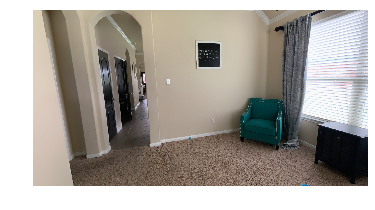

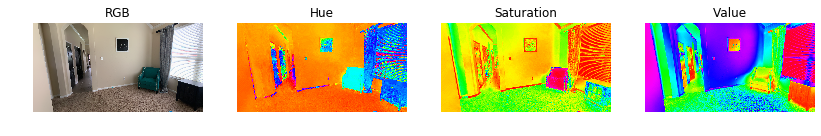

In [4]:
#file = '2.jpg'
file = 'img0.png'
# file = './Fwd_ floor segmentation proposal/image1.jpeg'

# img = img_as_float(io.imread(file)) # ??  
img = io.imread(file)  
imh, imw, imc = img.shape

img = transform.resize(img, (int(imh/2), int(imw/2)))
imh, imw, imc = img.shape
print(img.shape)

# ---- edge map file
file_ed = 'edgemap5_0.png'
edges_map = io.imread(file_ed) 
edges_map = transform.resize(edges_map, (imh, imw))

gimg = color.rgb2gray(img)
hsvimg = color.rgb2hsv(img)

rgbhsv = np.dstack((img,hsvimg)) 
himg = hsvimg[:,:,0]
simg = hsvimg[:,:,1]
vimg = hsvimg[:,:,2]

plt.figure(), plt.imshow(img), plt.axis('off');

fig, axes = plt.subplots(ncols=4, figsize=(14, 2))
axes[0].imshow(img)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(hsvimg[:,:,0],  cmap='hsv')
axes[1].set_title('Hue')
axes[1].axis('off')
axes[2].imshow(hsvimg[:,:,1],  cmap='hsv')
axes[2].set_title('Saturation');
axes[2].axis('off')
axes[3].imshow(hsvimg[:,:,2],  cmap='hsv')
axes[3].set_title('Value')
axes[3].axis('off');

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


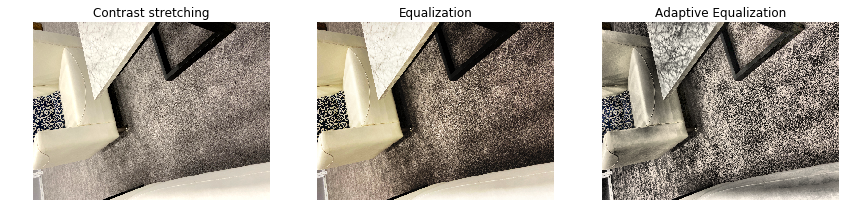

In [131]:
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes[0].set_title('Contrast stretching')
axes[0].imshow(img_rescale)
axes[0].axis('off')
axes[1].set_title('Equalization')
axes[1].imshow(img_eq)
axes[1].axis('off')
axes[2].set_title('Adaptive Equalization')
axes[2].imshow(img_adapteq)
axes[2].axis('off')
fig.tight_layout();

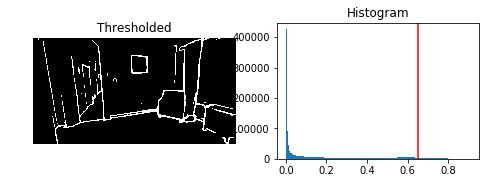

In [141]:
# thresh = filters.threshold_otsu(edges_map)
thresh = 0.65
edge_binary = edges_map.copy()
edge_binary[edge_binary > thresh] = np.max(edges_map)
edge_binary[edge_binary <= thresh] = 0
# plt.figure(), plt.imshow(binary), plt.axis('off');

fig, ax = plt.subplots(ncols=2, figsize=(8, 2.5))

ax[0].imshow(edge_binary, cmap=plt.cm.gray)
ax[0].set_title('Thresholded')
ax[0].axis('off')

ax[1].hist(edges_map.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r');

## SLIC

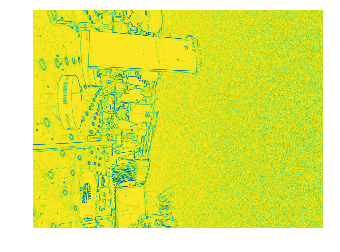

In [97]:
# median filter for 3 color channels
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.exposure import rescale_intensity

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

@adapt_rgb(each_channel)
def median_each(image):
    return filters.median(image)

@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

hsv_sobel = rescale_intensity(1 - sobel_hsv(img))
hsv_sobel = color.rgb2gray(hsv_sobel)
# tmp = rescale_intensity(1 - median_each(img))

plt.figure(), plt.imshow(hsv_sobel), plt.axis('off');

2.170896781994088 sec to process


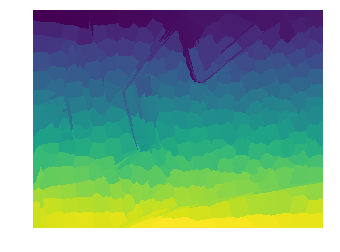

In [134]:
# Initial segmentation - the first step
start = timeit.default_timer()
num_segmnts = 300
labels = slic(img, n_segments = num_segmnts, sigma = 5, compactness = 7) # enforce_connectivity = True ?? 
stop = timeit.default_timer()
segments = color.label2rgb(labels, img, kind='avg')
plt.figure(), plt.imshow(labels), plt.axis('off');

print("{} sec to process".format((stop - start)))

### Graph Clusterization 

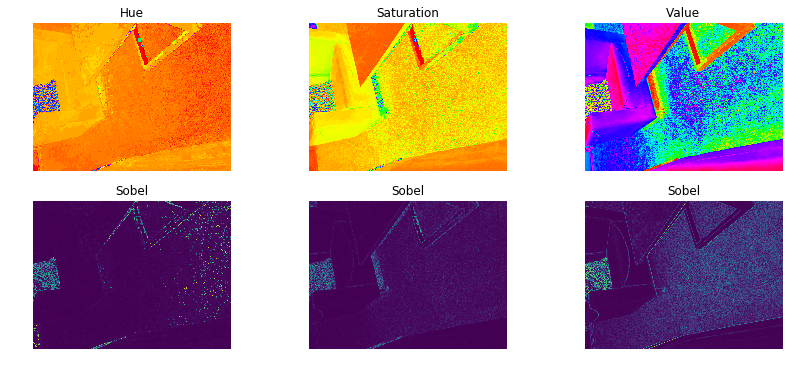

In [125]:
sobel_h = filters.sobel(himg)
sobel_s = filters.sobel(simg)
sobel_v = filters.sobel(vimg)

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(14, 6)) #  figsize=(14, 2)
axes[0,0].imshow(himg,cmap='hsv')
axes[0,0].set_title('Hue')
axes[0,0].axis('off')
axes[0,1].imshow(simg,  cmap='hsv')
axes[0,1].set_title('Saturation')
axes[0,1].axis('off')
axes[0,2].imshow(vimg,  cmap='hsv')
axes[0,2].set_title('Value');
axes[0,2].axis('off')

axes[1,0].imshow(sobel_h)
axes[1,0].set_title('Sobel')
axes[1,0].axis('off')
axes[1,1].imshow(sobel_s)
axes[1,1].set_title('Sobel')
axes[1,1].axis('off')
axes[1,2].imshow(sobel_v)
axes[1,2].set_title('Sobel')
axes[1,2].axis('off');

0.7905694150420948
0.0


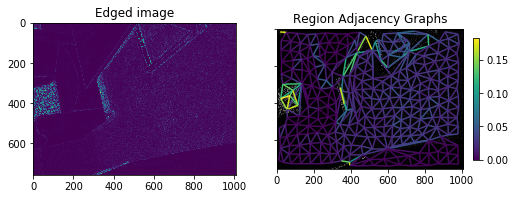

In [132]:
# --- Graph boundary ---
edges = filters.sobel(simg) 
# edges = filters.sobel(vimg) 

# edges = filters.laplace(hsvimg[:,:,1]) # No! 
# edges = filters.sobel(filters.gaussian(hsvimg[:,:,1], sigma = 3)) # No for 3 image 
# edges = feature.canny(gimg, sigma=1) # No!
# edges = filters.sobel(gimg) # No
# edges = filters.roberts(hsvimg[:,:,1]) # No big difference - more rectangular edges
# edges = filters.prewitt(hsvimg[:,:,1]) # No big difference
# edges = filters.scharr(simg)

# edges = hsv_sobel

# edges = edge_binary
# edges = eroded
edges_rgb = color.gray2rgb(edges)

#  Graph
g_edg = graph.rag_boundary(labels, edges)

fig, axes = plt.subplots(1,2, figsize=(8, 3), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(edges)
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(labels, g_edg, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
fig.colorbar(lc, fraction=0.03);

# plt.figure(), plt.imshow(edges), plt.axis('off');

0.04852805299742613 sec to process


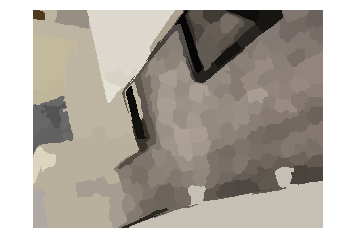

In [128]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }

def merge_boundary(graph, src, dst):
    pass

start = timeit.default_timer()
labels_hier_slic = graph.merge_hierarchical(labels, g_edg, thresh=0.01, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

stop = timeit.default_timer()
print("{} sec to process".format((stop - start)))

hierarchical_slic = color.label2rgb(labels_hier_slic, img, kind='avg')
plt.figure(), plt.imshow(hierarchical_slic), plt.axis('off');

##       SEEDs segmentations 

Final number of superpixels: 165


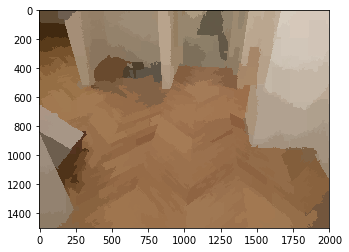

In [224]:
num_iterations = 4
prior = 2
double_step = False
num_superpixels = 200
num_levels = 10
num_bins = 5

seeds = cv2.ximgproc.createSuperpixelSEEDS(imw, imh, imc, num_superpixels, num_levels, prior, num_bins)
# seeds.iterate(cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT), num_iterations)
seeds.iterate(img, num_iterations)

num_of_superpixels_result = seeds.getNumberOfSuperpixels()
print('Final number of superpixels: %d' % num_of_superpixels_result)

slabels = seeds.getLabels()
seed_img = color.label2rgb(slabels, img, kind='avg')
plt.figure(), plt.imshow(seed_img);

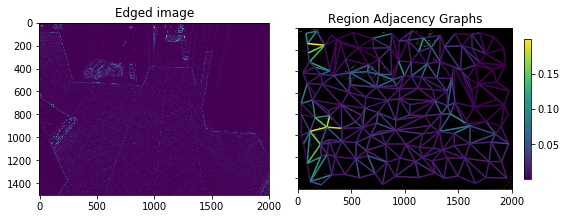

In [226]:
# --- Graph boundary ---
edges = filters.sobel(hsvimg[:,:,1]) 
edges_rgb = color.gray2rgb(edges)

#  Graph
g_edg1 = graph.rag_boundary(slabels, edges)

fig, axes = plt.subplots(1,2, figsize=(8, 3), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(edges)
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(slabels, g_edg1, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
fig.colorbar(lc, fraction=0.03)

fig.tight_layout()

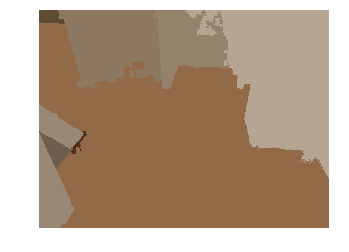

In [227]:
hlabels = graph.merge_hierarchical(slabels, g_edg1, thresh=0.035, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

hierarchical_seed = color.label2rgb(hlabels, img, kind='avg')

# fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
# axes[0].set_title('SEEDs')
# axes[0].imshow(seed_img)
# axes[0].axis('off')
# axes[1].set_title('SEEDs + merge_hierarchical')
# axes[1].imshow(hierarchical_seed)
# axes[1].axis('off')
# fig.tight_layout();
plt.figure(), plt.imshow(hierarchical_seed), plt.axis('off');

### Comparing SLIC and SEED

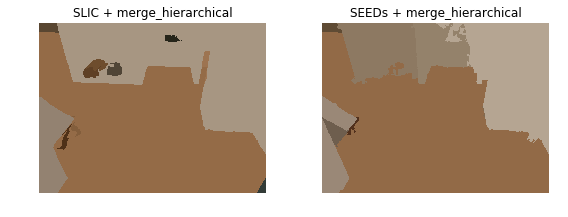

In [229]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].set_title('SLIC + merge_hierarchical')
axes[0].imshow(hierarchical_slic)
axes[0].axis('off')
axes[1].set_title('SEEDs + merge_hierarchical')
axes[1].imshow(hierarchical_seed)
axes[1].axis('off')
fig.tight_layout();

## Local binary pattern and hierarchical cut graph

False


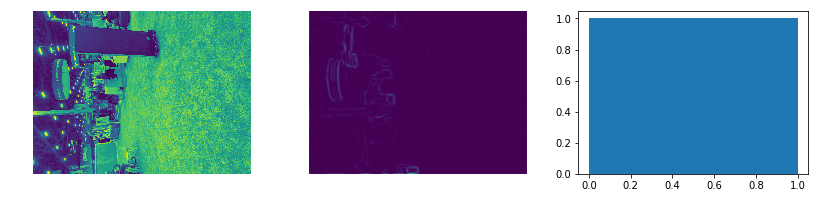

In [115]:
from skimage.feature import local_binary_pattern

# METHOD = 'uniform' # Ok
# METHOD = 'default' # heavy?
# METHOD = 'ror' # heavy?
# METHOD = 'nri_uniform'
METHOD = 'var' # NaN appears
radius = 3
n_points = 8 * radius
# lbp = local_binary_pattern(simg, n_points, radius, METHOD)
lbp = local_binary_pattern(filters.gaussian(simg, sigma=5), n_points, radius, METHOD)

# Handle missing value
lbp[np.isnan(lbp)] = np.nanmean(lbp)
print(np.isnan(lbp).any())

fig, axis = plt.subplots(1,3,  figsize=(14, 3))
axis[0].imshow(gimg), axis[0].axis('off')
axis[1].imshow(lbp), axis[1].axis('off')
n_bins = int(lbp.max() + 1)
axis[2].hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins));

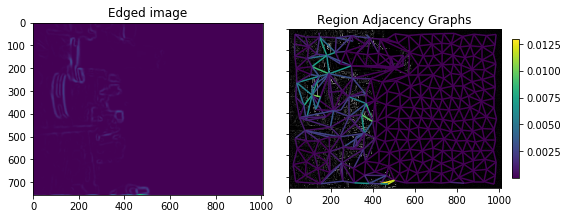

In [116]:
#  Graph
g_edg = graph.rag_boundary(labels, lbp)

fig, axes = plt.subplots(1,2, figsize=(8, 3), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(lbp)
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(labels, g_edg, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
fig.colorbar(lc, fraction=0.03)

fig.tight_layout()

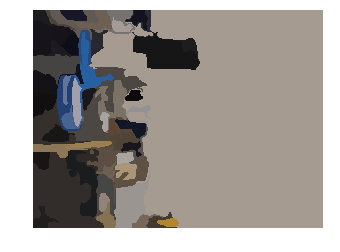

In [118]:
labels_hier_slic = graph.merge_hierarchical(labels, g_edg, thresh=0.00025, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

hierarchical_slic = color.label2rgb(labels_hier_slic, img, kind='avg')
plt.figure(), plt.imshow(hierarchical_slic)
plt.axis('off');

## Result 

In [89]:
def floor_label(labels):
    """takes the lable value from the central lower part of image"""
    h, w = labels.shape
    return labels[int(h*0.8), int(w*0.5)]

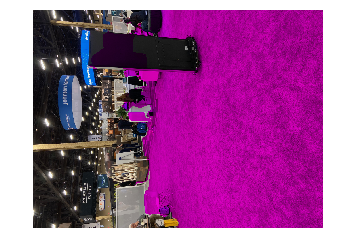

In [119]:
target_label = floor_label(labels_hier_slic)
mask = np.zeros(labels_hier_slic.shape)
mask[labels_hier_slic != target_label] = 1

dst = img.copy()
dst[:,:,1] = dst[:,:,1] * mask
plt.figure(), plt.imshow(dst), plt.axis('off');

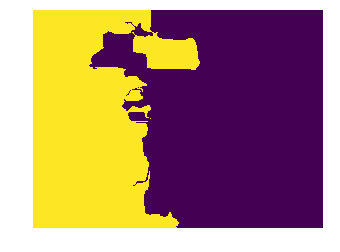

In [120]:
plt.figure(), plt.imshow(mask), plt.axis('off');

### Line detection

53


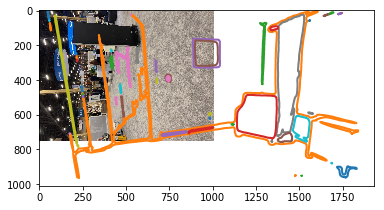

In [114]:
# thresholding
# thresh = filters.threshold_otsu(simg)
# thresh = filters.threshold_otsu(filters.gaussian(simg))
# binary = simg > thresh
# threshimg = simg>thresh

# contours 
contours = measure.find_contours(edge_binary, 0.8)
# contours = measure.find_contours(eroded, 0.8)
print(len(contours))

# show
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [32]:
lineH = []
lineV = []

if lines is not None:
    for [[x1, y1, x2, y2]] in lines:
        angle = round(np.arctan2(y2 - y1, x2 - x1)
                        * 180. / np.pi, 2)
        # log.debug("angle: {} degree".format(angle))
        if angle < 45 and angle > -45:  # Horizontal Lines
            # 45 degree +/- from horizontal Axes
            lineH.append(((x1, y1), (x2, y2)))
        elif (angle > 85 and angle < 95) or (angle > -95 and angle < -85):  # Vertical Lines
            # 5 degree +/- from Vertical Axes
            lineV.append(((x1, y1), (x2, y2)))
        else:
            continue
else:
    log.error("no lines found with HoughLineP")
    
plt.figure()
#cv2.drawContours(floor_seg.gray_image, contours, -1, (0,255,0), 3)
plt.imshow(edges_image);

NameError: name 'lines' is not defined

In [33]:
def polar2cartesian(rho: float, theta_rad: float, rotate90: bool = False):
    """
    Converts line equation from polar to cartesian coordinates

    Args:
        rho: input line rho
        theta_rad: input line theta
        rotate90: output line perpendicular to the input line

    Returns:
        m: slope of the line
           For horizontal line: m = 0
           For vertical line: m = np.nan
        b: intercept when x=0
    """
    x = np.cos(theta_rad) * rho
    y = np.sin(theta_rad) * rho
    m = np.nan
    if not np.isclose(x, 0.0):
        m = y / x
    if rotate90:
        if m is np.nan:
            m = 0.0
        elif np.isclose(m, 0.0):
            m = np.nan
        else:
            m = -1.0 / m
    b = 0.0
    if m is not np.nan:
        b = y - m * x

    return m, b 

def intersection(m1: float, b1: float, m2: float, b2: float):
    # Consider y to be equal and solve for x
    # Solve:
    #   m1 * x + b1 = m2 * x + b2
    x = (b2 - b1) / (m1 - m2)
    # Use the value of x to calculate y
    y = m1 * x + b1

    return int(round(x)), int(round(y))

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)